In [82]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import plotly.express as px 

In [83]:
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import  train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,OrdinalEncoder,OneHotEncoder 
from sklearn.linear_model import LinearRegression,LogisticRegression 
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier 
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.metrics import accuracy_score,mean_squared_log_error,r2_score,silhouette_score,confusion_matrix

In [84]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-5-hcv.csv')
data.head(2)

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


In [86]:
data.describe()

,Unnamed: 0,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.000000,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000
mean,308.000000,47.408130,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,177.679487,10.055105,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636
min,1.000000,19.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,154.500000,39.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000
50%,308.000000,47.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000
75%,461.500000,54.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000
max,615.000000,77.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


In [87]:
data.tail(2)

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
613,614,3=Cirrhosis,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.2,52.0,50.0,71.0
614,615,3=Cirrhosis,59,f,36.0,NaN,100.0,80.0,12.0,9.07,5.3,67.0,34.0,68.0


In [88]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [89]:
mis_val = data.isna().sum() * 100/len(data)

mis_val.sort_values(ascending=False)


ALP         2.926829
CHOL        1.626016
ALB         0.162602
ALT         0.162602
PROT        0.162602
Category    0.000000
Age         0.000000
Sex         0.000000
AST         0.000000
BIL         0.000000
CHE         0.000000
CREA        0.000000
GGT         0.000000
dtype: float64

In [90]:
data.duplicated().sum()

0

In [91]:
mean_imp = SimpleImputer(missing_values=np.NaN, strategy='mean')

data[['ALP', 'CHOL', 'ALB', 'ALT', 'PROT']] = mean_imp.fit_transform(data[['ALP', 'CHOL', 'ALB', 'ALT', 'PROT']])


In [92]:
mis_val = data.isna().sum() * 100/len(data)

mis_val.sort_values(ascending=False)

Category    0.0
Age         0.0
Sex         0.0
ALB         0.0
ALP         0.0
ALT         0.0
AST         0.0
BIL         0.0
CHE         0.0
CHOL        0.0
CREA        0.0
GGT         0.0
PROT        0.0
dtype: float64

<AxesSubplot:title={'center':'Correlation Matrix'}>

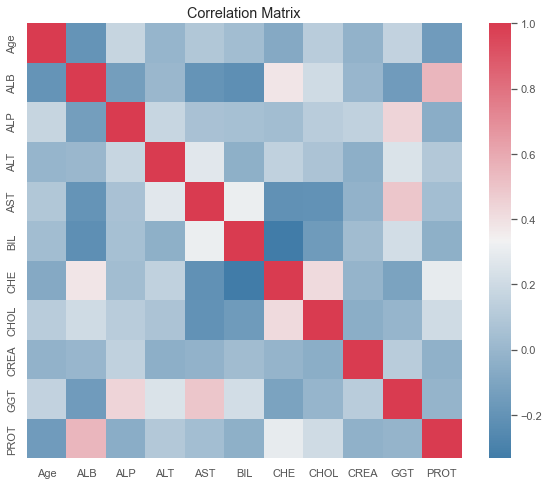

In [93]:
data_corr = data.corr()
f,ax = plt.subplots(figsize=(10,8))
ax.set_title('Correlation Matrix')

sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_), cmap=sns.diverging_palette(240, 8, as_cmap=True), ax=ax, square=True)

In [94]:
orig_categ = data.Category

le = LabelEncoder()

y = data.Category 
y_true = le.fit_transform(y)

data = pd.get_dummies(data, dtype=float)
data

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Category_0=Blood Donor,Category_0s=suspect Blood Donor,Category_1=Hepatitis,Category_2=Fibrosis,Category_3=Cirrhosis,Sex_f,Sex_m
0,32,38.5,52.50000,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,32,38.5,70.30000,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,32,46.9,74.70000,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,32,43.2,52.00000,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,32,39.2,74.10000,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,62,32.0,416.60000,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0
611,64,24.0,102.80000,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,0.0,0.0,0.0,0.0,1.0,1.0,0.0
612,64,29.0,87.30000,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
613,46,33.0,68.28392,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
